In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from ai_quantum.quantum.qaoa import QAOA
from ai_quantum.initialstates.dicke_initialstate import dicke_statevector
from ai_quantum.utils.matrix_compression import opt_sort_matrix_ring, compress_matrix
from return_cov import f_return_cov
import networkx as nx

%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
expected_value, cov_matrix = f_return_cov()

## Cov Matrix compression

In [3]:
opt_perm = opt_sort_matrix_ring(np.array(cov_matrix))

q_graph = [
 (opt_perm[i], opt_perm[np.mod(i+1, len(expected_value))]) 
 for i in range(len(expected_value))
]
q_graph

[(0, 1), (1, 3), (3, 4), (4, 2), (2, 0)]

In [4]:
G = nx.Graph()
G.add_edges_from(q_graph)
lam, compress_cov_matrix = compress_matrix(cov_matrix[opt_perm], G)
compress_cov_matrix = pd.DataFrame(compress_cov_matrix)

## ----------

In [5]:
# Define the objective function to be optimized
q = 0.5 
B  = 2 
lamb= 0
depth = 10
qc_initial_state = dicke_statevector(len(expected_value), B)
def objective(params):
    gamma = params[:depth]
    beta = params[depth:]
    qaoa = QAOA(expected_value, compress_cov_matrix, q, B, lamb, qc=qc_initial_state, 
                mixture_layer='ring_mixer', q_graph=q_graph)
    for i in range(depth):
        qaoa.add_layer(gamma[i], beta[i])

    energy, _ = qaoa.measure_energy()
    return energy

# Specify the initial parameters for optimization.
vec_gamma = []
vec_beta = []
initial_params = []
for _ in range(depth):
    gamma = np.random.uniform(0, 2*np.pi)
    beta = np.random.uniform(0, 2*np.pi)
    vec_gamma.append(gamma)
    vec_beta.append(beta)
    initial_params.append(gamma)
    initial_params.append(beta)

## Global optimal solution

In [ ]:
from ai_quantum.utils.cost_function import sort_by_cost_function
df = sort_by_cost_function(expected_value, cov_matrix, q, lamb, B)

In [7]:
df

,solution,cost_function
0,"(1, 0, 1, 0, 0)",-0.339114
1,"(0, 0, 1, 1, 0)",-0.309707
2,"(1, 0, 0, 1, 0)",-0.279361
3,"(0, 0, 1, 0, 1)",-0.244644
4,"(1, 0, 0, 0, 1)",-0.212269
5,"(0, 0, 0, 1, 1)",-0.169331
6,"(0, 1, 1, 0, 0)",-0.006530
7,"(1, 1, 0, 0, 0)",0.029109
8,"(0, 1, 0, 1, 0)",0.061111
9,"(0, 1, 0, 0, 1)",0.122858


## --------

In [8]:
result = minimize(objective, initial_params, method='COBYLA')

gamma = result.x[:depth]
beta = result.x[depth:]

In [9]:
# Generate the optimal circuit.
qaoa = QAOA(expected_value, compress_cov_matrix, q, B, lamb, qc=qc_initial_state, 
            mixture_layer='ring_mixer', q_graph=q_graph)
for i in range(depth):
    qaoa.add_layer(gamma[i], beta[i])
    
energy, counts = qaoa.measure_energy()
energy

np.float64(-0.4609773297192771)

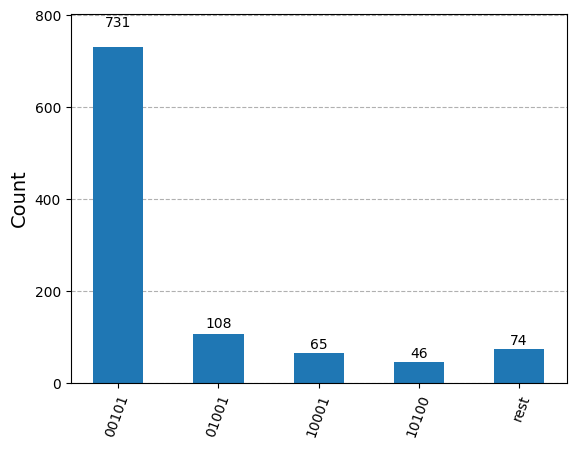

In [10]:
plot_histogram(counts, number_to_keep=4)
plt.show()

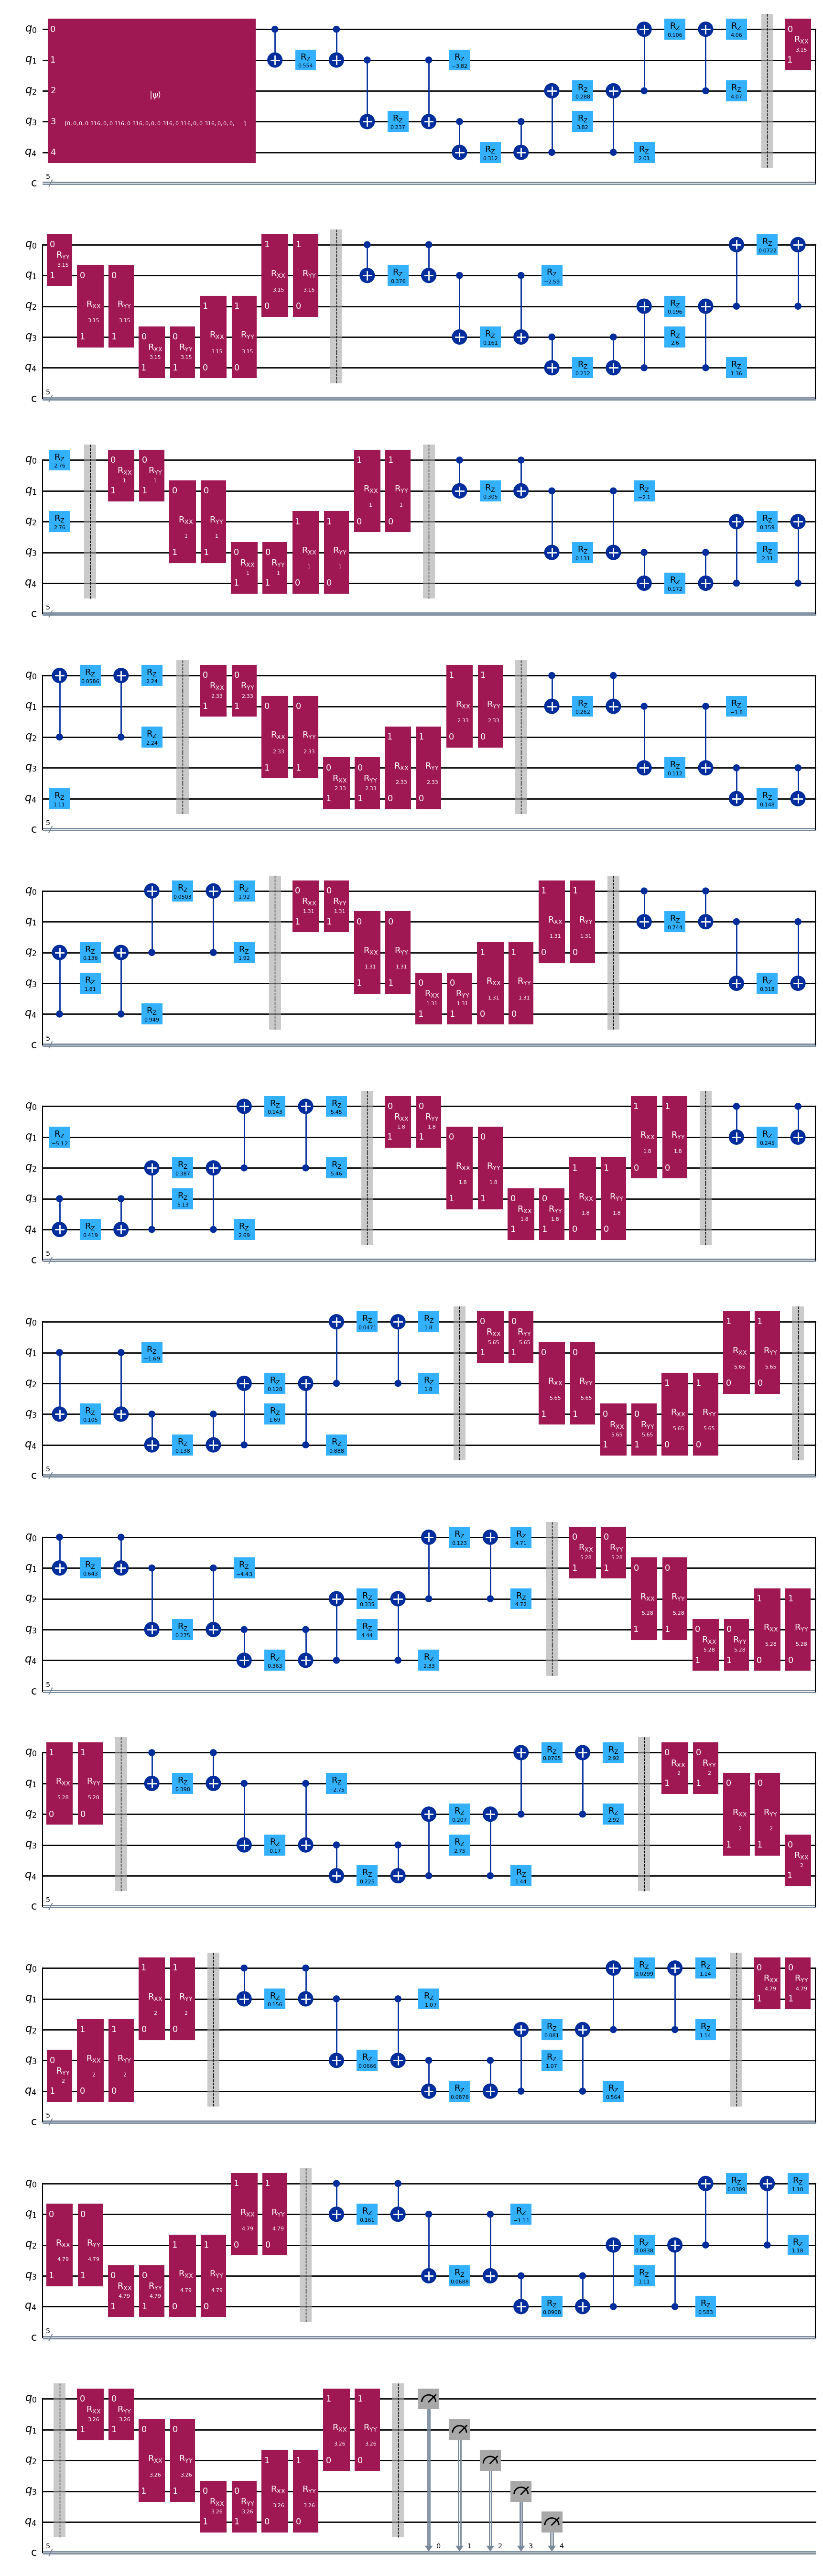

In [11]:
qaoa.draw()